In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import zipfile
# from natsort import natsorted
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
# from model import VAE

import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchmetrics

%reload_ext autoreload
%autoreload 2

/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load dataset
device = torch.device("cuda")
cpu_device = torch.device("cpu")

In [3]:
DATA_DIR_PATH = "autoencoders/dataset"
DATA_PATH = os.path.join(DATA_DIR_PATH, 'animal-faces')
DATA_URL = 'https://www.kaggle.com/datasets/andrewmvd/animal-faces/download?datasetVersionNumber=1'
device = torch.device("cuda")
cpu_device = torch.device("cpu")

class AnimalfaceDataset(Dataset):
    def __init__(self, transform, type='train', label_dict = {"dog":0, "cat":1, "wild":2} , img_width=128) -> None:
        self.transform = transform
        # self.root_dir specifies weather you are at afhq/train or afhq/val directory
        self.label_dict = label_dict
        self.root_dir = os.path.join(DATA_PATH, type)
        assert os.path.exists(self.root_dir), "Check for the dataset, it is not where it should be. If not present, you can download it by clicking above DATA_URL"
        subdir = os.listdir(self.root_dir)
        self.image_names = []
        
        for category in subdir:
            subdir_path = os.path.join(self.root_dir, category)
            self.image_names+=os.listdir(subdir_path)

        self.img_arr = torch.zeros((len(self.image_names), 3, img_width ,img_width))
        self.labels = torch.zeros(len(self.image_names))
            
        for i,img_name in enumerate(tqdm(self.image_names)):
            label = self.label_dict[img_name.split("_")[1]]
            img_path = os.path.join(self.root_dir, img_name.split("_")[1], img_name)
            # Load image and convert it to RGB
            img = Image.open(img_path).convert('RGB')
            # Apply transformations to the image
            img = self.transform(img)
            self.img_arr[i] = img
            self.labels[i] = label
            
    def __getitem__(self, idx):
        return self.img_arr[idx], self.labels[idx]
    
    def __len__(self):
        return len(self.image_names)

In [7]:
width = 128
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])

In [8]:
train_data = AnimalfaceDataset(transform=train_transform, img_width=width)

  0%|                                                                                                                         | 0/14630 [00:00<?, ?it/s]/data3/home/karmpatel/miniconda3/envs/torch310/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████████████████

In [9]:
val_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((width,width))])
val_data = AnimalfaceDataset(transform=val_transform, type="val", img_width=width)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:26<00:00, 56.51it/s]


In [28]:
def show_img(x):
    plt.figure(figsize=(2,2))
    plt.imshow(x.permute(0,2,3,1).detach().to(cpu_device).numpy()[0])

torch.Size([512, 3, 128, 128]) torch.Size([512])


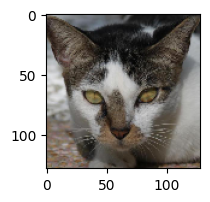

In [29]:
BATCH_SIZE = 512
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
x, y = next(iter(val_loader))
print(x.shape, y.shape)
show_img(x)

# Q1 - GMM

# Q2 - Vanila - VAE

In [10]:
class Encoder_vae(nn.Module):
    def __init__(self, filters,  kernel_sizes,  strides, hiddens_sizes, paddings, 
                 return_only_conv=False, return_only_liner=False, droput_prob=0.1, curr_device="cuda", n_samples=5):
        super(Encoder_vae, self).__init__()
        
        self.curr_device = curr_device
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        self.n_samples = n_samples
        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.Conv2d(filters[i], filters[i+1], kernel_sizes[i], strides[i], paddings[i]))
            conv_layers.append(nn.ReLU(True))

        self.conv_layer = nn.Sequential(*conv_layers)

        hidden_layers = []
        hiddens_sizes_cpy = hiddens_sizes.copy()
        hiddens_sizes_cpy[-1] = hiddens_sizes_cpy[-1]*2 # mu and sigma
        for i in range(len(hiddens_sizes_cpy)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes_cpy[i], hiddens_sizes_cpy[i+1]))
            if i < len(hiddens_sizes_cpy)-2:
                hidden_layers.append(nn.ReLU(True))
        self.liner_layer = nn.Sequential(*hidden_layers)
       
    def forward(self, x):
        if self.return_only_conv:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            z = x
        elif self.return_only_liner:
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
            z = x
        else:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
            z = x

        z_dim = z.shape[-1]//2
        mu, log_var = z[:, :z_dim], z[:, z_dim:]
        sigma = torch.exp(0.5*log_var)
        eps = torch.randn((z_dim, self.n_samples)).to(torch.device(self.curr_device))
        z = []
        for i in range(self.n_samples):
            z.append(mu + sigma*eps[:,i])
        z = torch.stack(z)
        return z, mu, log_var

    
class Decoder(nn.Module):
    def __init__(self, conv_op_size,  filters, kernel_sizes, strides, output_paddings, 
                   paddings, hiddens_sizes, return_only_conv=False, return_only_liner=False, droput_prob=0.1):
        super(Decoder, self).__init__()
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        print(hiddens_sizes)
        
        hidden_layers = []
        for i in range(len(hiddens_sizes)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes[i], hiddens_sizes[i+1]))
            if i < len(hiddens_sizes)-2:
                hidden_layers.append(nn.ReLU(True))
        
        self.liner_layer = nn.Sequential(*hidden_layers)

        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.ConvTranspose2d(filters[i], filters[i+1], kernel_sizes[i], 
                                                  stride=strides[i], output_padding=output_paddings[i], padding=paddings[i]))
            if i < len(kernel_sizes)-1:
                conv_layers.append(nn.ReLU(True))

        self.conv_layer = nn.Sequential(*conv_layers)        
        self.unflatten = nn.Unflatten(dim=2, unflattened_size=conv_op_size)
        
        
    def forward(self, x):
        if self.return_only_conv:
            x = self.unflatten(x)
            x = self.conv_layer(x)
            x = torch.sigmoid(x)
            return x
        elif self.return_only_liner:
            # print(x.shape)
            x = self.liner_layer(x)
            x = self.unflatten(x)
            x = torch.sigmoid(x)
            return x
        else:
            x = self.liner_layer(x)
            x = self.unflatten(x)
            ans = []
            for each in x:
                ans.append(self.conv_layer(each))
            x_hat = torch.stack(ans)
            x_hat = torch.sigmoid(x_hat)
        return x_hat


class VAE(nn.Module):
    def __init__(self, feature_size=2048, conv_ip_size=(32, 14, 14), filters = [3,12,24,48,128],  
                 kernel_sizes = [3, 3, 3, 3], strides = [2, 2, 2, 2], output_paddings = [0,0,0,0], 
                 paddings = [0,0,0,0], hiddens_sizes = [2048, 1024, 512, 256, 3], return_only_conv=False, 
                 return_only_liner=False, droput_prob=0.2, n_samples=5):
        '''
        if return_only_liner=True, then conv_ip_size = (3, 128, 128) and hidden_sizes [3*128*128, ... , features_size]
        '''
        super(VAE, self).__init__()
        self.encoder_vae = Encoder_vae(filters=filters, 
                               kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hiddens_sizes, 
                               return_only_conv=return_only_conv, return_only_liner=return_only_liner, 
                               droput_prob=droput_prob, paddings=paddings, n_samples=5)
        
        self.decoder = Decoder(conv_op_size=conv_ip_size, filters=filters[::-1], 
                               kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings[::-1],
                                 paddings=paddings[::-1], hiddens_sizes=hiddens_sizes[::-1] , return_only_liner=return_only_liner)
    
    def forward(self,x):
        enc, mu, logvar = self.encoder_vae(x)
        x_hat = self.decoder(enc)
        x_hat_avg = x_hat.mean(dim=0)
        return x_hat_avg, enc, mu, logvar

    def loss_fn(self, x, x_hat, mu, logvar, beta=1):
        mse_loss = nn.MSELoss(reduction="sum")(x, x_hat)
        kl_loss = torch.sum(-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
        return mse_loss+ beta*kl_loss, mse_loss, kl_loss

# Q4 - Auto-encoder

### Model

In [19]:
class Encoder(nn.Module):
    def __init__(self, filters,  kernel_sizes,  strides, hiddens_sizes, paddings, 
                 return_only_conv=False, return_only_liner=False, droput_prob=0.1):
        super(Encoder, self).__init__()
        
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.Conv2d(filters[i], filters[i+1], kernel_sizes[i], strides[i], paddings[i]))
            conv_layers.append(nn.ReLU(True))

        self.conv_layer = nn.Sequential(*conv_layers)

        hidden_layers = []
        for i in range(len(hiddens_sizes)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes[i], hiddens_sizes[i+1]))
            if i < len(hiddens_sizes)-2:
                hidden_layers.append(nn.ReLU(True))

            # hidden_layers.append(nn.ReLU(True))
        self.liner_layer = nn.Sequential(*hidden_layers)
        
        
    def forward(self, x):
        if self.return_only_conv:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            return x
        elif self.return_only_liner:
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
            return x
        else:
            x = self.conv_layer(x)
            x = x.flatten(start_dim=1)
            x = self.liner_layer(x)
        return x

    
class Decoder(nn.Module):
    def __init__(self, conv_op_size,  filters, kernel_sizes, strides, output_paddings, 
                   paddings, hiddens_sizes, return_only_conv=False, return_only_liner=False, droput_prob=0.1):
        super(Decoder, self).__init__()
        self.return_only_conv = return_only_conv
        self.return_only_liner = return_only_liner
        print(hiddens_sizes)
        
        hidden_layers = []
        for i in range(len(hiddens_sizes)-1):
            hidden_layers.append(nn.Dropout(p=droput_prob))
            hidden_layers.append(nn.Linear(hiddens_sizes[i], hiddens_sizes[i+1]))
            if i < len(hiddens_sizes)-2:
                hidden_layers.append(nn.ReLU(True))
            # hidden_layers.append(nn.ReLU(True))
        
        self.liner_layer = nn.Sequential(*hidden_layers)

        conv_layers = []
        for i in range(len(kernel_sizes)):
            conv_layers.append(nn.ConvTranspose2d(filters[i], filters[i+1], kernel_sizes[i], 
                                                  stride=strides[i], output_padding=output_paddings[i], padding=paddings[i]))
            if i < len(kernel_sizes)-1:
                conv_layers.append(nn.ReLU(True))


        self.conv_layer = nn.Sequential(*conv_layers)
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=conv_op_size)
        
        
    def forward(self, x):
        if self.return_only_conv:
            x = self.unflatten(x)
            x = self.conv_layer(x)
            x = torch.sigmoid(x)
            return x
        elif self.return_only_liner:
            # print(x.shape)
            x = self.liner_layer(x)
            x = self.unflatten(x)
            x = torch.sigmoid(x)
            return x
        else:
            x = self.liner_layer(x)
            x = self.unflatten(x)
            x = self.conv_layer(x)
            x = torch.sigmoid(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self, feature_size=2048, conv_ip_size=(32, 14, 14), filters = [3,12,24,48,128],  
                 kernel_sizes = [3, 3, 3, 3], strides = [2, 2, 2, 2], output_paddings = [0,0,0,0], 
                 paddings = [0,0,0,0], hiddens_sizes = [2048, 1024, 512, 256, 3], return_only_conv=False, 
                 return_only_liner=False, droput_prob=0.2):
        '''
        if return_only_liner=True, then conv_ip_size = (3, 128, 128) and hidden_sizes [3*128*128, ... , features_size]
        '''
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(filters=filters, 
                               kernel_sizes=kernel_sizes,strides=strides, hiddens_sizes=hiddens_sizes, 
                               return_only_conv=return_only_conv, return_only_liner=return_only_liner, 
                               droput_prob=droput_prob, paddings=paddings)
        
        self.decoder = Decoder(conv_op_size=conv_ip_size, filters=filters[::-1], 
                               kernel_sizes=kernel_sizes[::-1],strides=strides[::-1], output_paddings=output_paddings[::-1],
                                 paddings=paddings[::-1], hiddens_sizes=hiddens_sizes[::-1] , return_only_liner=return_only_liner)
    
    def forward(self,x):
        enc = self.encoder(x)
        x = self.decoder(enc)
        return x, enc

In [17]:
feature_size = 128
filters = [3, 16, 32, 64, 128, 256]
kernel_sizes = [4, 4, 4, 4, 4]
strides = [2,2,2,2,2]
paddings = [0,0,0,0,0]
output_paddings = [0,1,0,0,0]
# paddings = [0,0]
return_only_liner = 0
dropout_prob = 0.0
conv_ip_size = (256,2,2)
hidden_sizes = [conv_ip_size[0]*conv_ip_size[1]*conv_ip_size[2], feature_size]  

ae = AutoEncoder(feature_size=feature_size, conv_ip_size=conv_ip_size, filters=filters, 
                 kernel_sizes=kernel_sizes,strides=strides,output_paddings=output_paddings, 
                 paddings=paddings, hiddens_sizes=hidden_sizes, return_only_liner=return_only_liner, droput_prob=dropout_prob).to(device)

[128, 1024]


### Training

In [ ]:
%%time
n_epochs = 100
loss_fn = nn.MSELoss()
optim = torch.optim.Adam(ae.parameters(), lr=1e-3)
losses = []
val_losses = []
for epoch in range(n_epochs):
    ae.train()
    tqdm_obj = tqdm(train_loader)
    for i, (X,y) in enumerate(tqdm_obj):
        X, y = X.to(device), y.to(device)
        optim.zero_grad()
        
        X_hat, enc = ae(X) # [B, feature_size]
        loss = loss_fn(X, X_hat)
        loss.backward()
        optim.step()

        tqdm_obj.set_description_str(f"Epoch: {epoch} Loss {loss}")
        if i%1 == 0:
            losses.append(loss.detach().to(cpu_device))
    
    with torch.no_grad(): # mandatory to write
        ae.eval()
        tqdm_obj = tqdm(val_loader)
        for i, (X,y) in enumerate(tqdm_obj):
            X, y = X.to(device), y.to(device)

            X_hat, enc = ae(X) # [B, feature_size]
            val_loss = loss_fn(X, X_hat)

            tqdm_obj.set_description_str(f"Epoch {epoch} Val Loss {val_loss}")
            if i%1 == 0:
                val_losses.append(val_loss.detach().to(cpu_device))
                

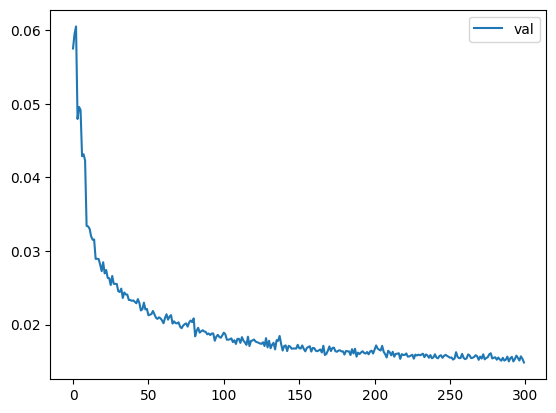

In [217]:
to_cpu = lambda arr: [each.detach().to(cpu_device) for each in arr]
# plt.plot(to_cpu(losses), label="train")
plt.plot(to_cpu(val_losses)[0:], label="val")
plt.legend()

In [18]:
ae.load_state_dict(torch.load(f'autoencoders/ckpts/autoencoder_{feature_size}_1l.pt'))

<All keys matched successfully>

### Reconstruction on Validation data

In [21]:
from torchvision.utils import save_image, make_grid

def plot_grid(generated_grid):
    plt.figure(figsize=(10,10))
    plt.imshow(generated_grid.permute(1,2,0).detach().to(cpu_device).numpy())

In [30]:
x, y = next(iter(val_loader))
x_hat, enc = ae(x.to(device))
generated_grid = make_grid(x_hat, nrow=10)
# save_image(generated_grid,f"generated_{feature_size}_1l.png")
plot_grid(generated_grid)

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [25]:
x.shape

torch.Size([100, 3, 128, 128])